# Backtesting

This projects builds a computationally effecient backtester for a market neutral portfolio using Barra data, the focus is on:
 - portfolio optimization accounting for transaction costs   
 - performance attribution to identify the major drivers portfolio's PnL
 
Factor return estimation and alpha combination have been intentionally kept simple to focus on the backtesting component



In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [64]:
import scipy
import patsy
import pickle

import numpy as np
import pandas as pd

import scipy.sparse
import matplotlib.pyplot as plt

from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols
from tqdm import tqdm

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)

## Load & Process Data
---

In [3]:
%ls ../../data/project_8_barra/

covariance.2003.pickle  pandas-frames.2003.pickle  price.2003.pickle
covariance.2004.pickle  pandas-frames.2004.pickle  price.2004.pickle
covariance.2005.pickle  pandas-frames.2005.pickle  price.2005.pickle
covariance.2006.pickle  pandas-frames.2006.pickle  price.2006.pickle
covariance.2007.pickle  pandas-frames.2007.pickle  price.2007.pickle
covariance.2008.pickle  pandas-frames.2008.pickle  price.2008.pickle


In [4]:
barra_dir = '../../data/project_8_barra/'

data = {}
for year in [2006, 2007]:
    fil = barra_dir + "pandas-frames." + str(year) + ".pickle"
    data.update(pickle.load( open( fil, "rb" ) ))
    
covariance = {}
for year in [2006, 2007]:
    fil = barra_dir + "covariance." + str(year) + ".pickle"
    covariance.update(pickle.load( open(fil, "rb" ) ))
    
daily_return = {}
for year in [2006, 2007, 2008]:
    fil = barra_dir + "price." + str(year) + ".pickle"
    daily_return.update(pickle.load( open(fil, "rb" ) ))

In [5]:
test_date = '20060106'

In [6]:
data[test_date].head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,BidAskSpread,DailyVolume,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate
0,USA0001,-0.146,0.000,0.0,0.0,0.0,0.0,0.0,-2.460,0.0,...,NaN,NaN,NaN,6.067568e+10,1.386001,13.002634,9.467769,-0.010980,0.237318,20060106
1,USA0011,-0.389,0.000,0.0,0.0,0.0,0.0,0.0,-2.434,0.0,...,NaN,NaN,NaN,1.110398e+10,0.000000,17.036766,12.836332,-0.000220,0.241841,20060106
2,USA0031,-0.005,0.000,0.0,0.0,0.0,0.0,0.0,-2.439,0.0,...,NaN,1330.0,NaN,6.356007e+10,2.789754,25.490823,23.320534,-0.002087,0.301441,20060106
3,USA0062,0.055,0.436,0.0,0.0,0.0,0.0,0.0,-2.372,0.0,...,NaN,NaN,NaN,3.238442e+10,2.214765,18.320292,16.682618,0.025770,0.387660,20060106
4,USA00E2,-0.036,0.000,0.0,0.0,0.0,0.0,0.0,-2.481,0.0,...,NaN,850.0,NaN,6.405457e+10,2.170610,23.393174,21.101442,-0.028187,0.326749,20060106


In [7]:
daily_return[test_date].head()

,Barrid,DlyReturn
147,USA0001,0.0
148,USA0011,0.0
149,USA0031,0.0
150,USA0062,0.0
151,USA00E2,0.0


In [8]:
covariance[test_date].head()

,Factor1,Factor2,VarCovar,DataDate
0,USFASTD_1DREVRSL,USFASTD_1DREVRSL,1.204131,20060106
1,USFASTD_1DREVRSL,USFASTD_BETA,0.380109,20060106
2,USFASTD_1DREVRSL,USFASTD_DIVYILD,0.035375,20060106
3,USFASTD_1DREVRSL,USFASTD_DWNRISK,-0.011983,20060106
4,USFASTD_1DREVRSL,USFASTD_EARNQLTY,0.091624,20060106


**Shift Daily Returns**

 - incorporate a realistic two-day delay for trade execution
 - ex. `frames['20040108']` will get the prices from `20040108` and the data from `20040106`

In [9]:
frames ={}
dlyreturn_n_days_delay = 2

date_shifts = zip(sorted(data.keys()), 
                  sorted(daily_return.keys())[dlyreturn_n_days_delay:len(data) + dlyreturn_n_days_delay])

for data_date, price_date in date_shifts:
    frames[price_date] = data[data_date].merge(daily_return[price_date], on='Barrid')


In [10]:
# Adding Daily Returns Data Column
for price_date, df in frames.items():
    n_rows = df.shape[0]
    df['DlyReturnDate'] = pd.Series([price_date]*n_rows)

**Winsorize**

In [11]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

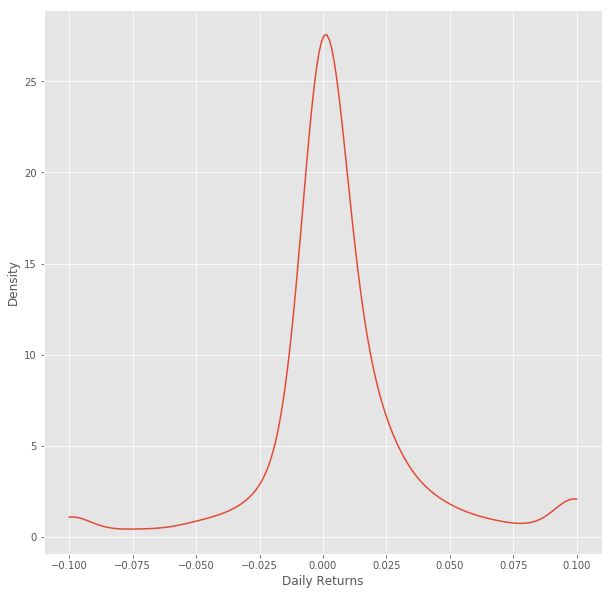

In [65]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()
    
test = frames[test_date]
test['DlyReturn'] = wins(test['DlyReturn'],-0.1,0.1)
density_plot(test['DlyReturn'])

## Factor Exposures and Factor Returns

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
 - $i=1...N$ (N assets)   
 - $j=1...k$ (k factors)

Where:
 - $r_{i,t}$: return on asset
 - $\beta_{i,j,t-2}$: factor exposures
 - $f_{j,t}$: factor returns 
 
Will Ordinary Least Squares (OLS) method to estimate $f_{j,t}$

In [13]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(filter(lambda x: "USFASTD_" in x, n))

def estimate_factor_returns(df): 
    ## build universe based on filters 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  
    ## winsorize returns for fitting 
    estu['DlyReturn'] = wins(estu['DlyReturn'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "DlyReturn")
    model = ols(form, data=estu)
    results = model.fit()
    return results

OLS formula:

In [14]:
get_formula(factors_from_names(list(frames[test_date])), "DlyReturn")

'DlyReturn ~ 0 + USFASTD_1DREVRSL + USFASTD_AERODEF + USFASTD_AIRLINES + USFASTD_ALUMSTEL + USFASTD_APPAREL + USFASTD_AUTO + USFASTD_BANKS + USFASTD_BETA + USFASTD_BEVTOB + USFASTD_BIOLIFE + USFASTD_BLDGPROD + USFASTD_CHEM + USFASTD_CNSTENG + USFASTD_CNSTMACH + USFASTD_CNSTMATL + USFASTD_COMMEQP + USFASTD_COMPELEC + USFASTD_COMSVCS + USFASTD_CONGLOM + USFASTD_CONTAINR + USFASTD_DISTRIB + USFASTD_DIVFIN + USFASTD_DIVYILD + USFASTD_DWNRISK + USFASTD_EARNQLTY + USFASTD_EARNYILD + USFASTD_ELECEQP + USFASTD_ELECUTIL + USFASTD_FOODPROD + USFASTD_FOODRET + USFASTD_GASUTIL + USFASTD_GROWTH + USFASTD_HLTHEQP + USFASTD_HLTHSVCS + USFASTD_HOMEBLDG + USFASTD_HOUSEDUR + USFASTD_INDMACH + USFASTD_INDMOM + USFASTD_INSURNCE + USFASTD_INTERNET + USFASTD_LEISPROD + USFASTD_LEISSVCS + USFASTD_LEVERAGE + USFASTD_LIFEINS + USFASTD_LIQUIDTY + USFASTD_LTREVRSL + USFASTD_MEDIA + USFASTD_MGDHLTH + USFASTD_MGMTQLTY + USFASTD_MIDCAP + USFASTD_MOMENTUM + USFASTD_MULTUTIL + USFASTD_OILGSCON + USFASTD_OILGSDRL + US

In [15]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date]).params
    
facret[test_date].head()

USFASTD_1DREVRSL    0.000058
USFASTD_AERODEF     0.013213
USFASTD_AIRLINES    0.004444
USFASTD_ALUMSTEL    0.010448
USFASTD_APPAREL     0.006863
dtype: float64

In [16]:
dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))

## Alpha Factors
---

Factors selected:

* **USFASTD_1DREVRSL** : Reversal

* **USFASTD_EARNYILD** : Earnings Yield

* **USFASTD_VALUE** : Value

* **USFASTD_SENTMT** : Sentiment

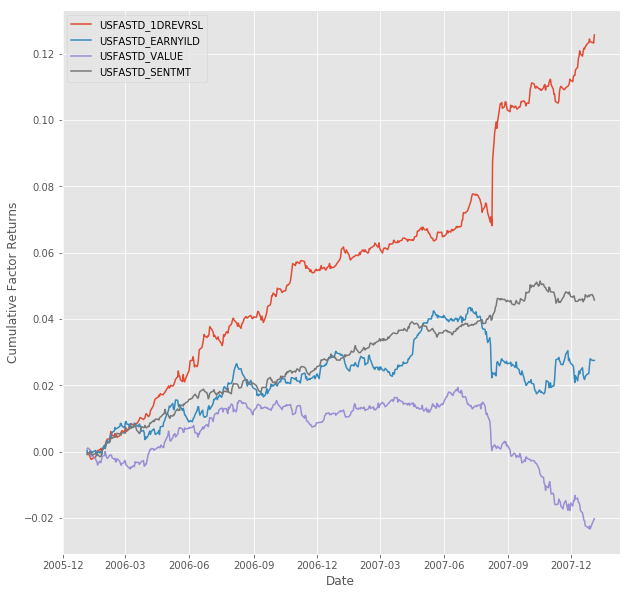

In [66]:
alpha_factors = ["USFASTD_1DREVRSL", "USFASTD_EARNYILD", "USFASTD_VALUE", "USFASTD_SENTMT"]

facret_df = pd.DataFrame(index = dates)

for dt in dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

for column in facret_df.columns:
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

## Holdings, Universe, Risk Factors
---

 - previous day's holdings to estimate the trade size and transaction costs

In [18]:
def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

In [19]:
previous_holdings = pd.DataFrame(data = {"Barrid" : ["USA02P1"], "h.opt.previous" : np.array(0)})
df = frames[dates[0].strftime('%Y%m%d')]

df = df.merge(previous_holdings, how = 'left', on = 'Barrid')
df = clean_nas(df)

# cleaning up Barra's specific risk if = 0
df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])

df.head()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,DlyReturnDate,h.opt.previous
0,USA0001,-0.067,0.000,0.0,0.0,0.0,0.0,0.0,-2.428,0.0,...,5.998757e+10,1.386001,12.030544,8.451849,-0.009918,0.237712,20060103,0.000000,20060105,0.0
1,USA0011,-0.100,0.000,0.0,0.0,0.0,0.0,0.0,-2.405,0.0,...,1.058144e+10,0.000000,15.439825,11.122402,-0.000165,0.256895,20060103,0.000000,20060105,0.0
2,USA0031,0.211,0.000,0.0,0.0,0.0,0.0,0.0,-2.417,0.0,...,6.147715e+10,2.789754,22.880010,20.615107,-0.005203,0.278277,20060103,-0.008150,20060105,0.0
3,USA0062,-0.447,0.436,0.0,0.0,0.0,0.0,0.0,-2.343,0.0,...,3.203381e+10,2.214765,16.103513,14.385974,0.025686,0.362474,20060103,-0.020942,20060105,0.0
4,USA00E2,0.241,0.000,0.0,0.0,0.0,0.0,0.0,-2.463,0.0,...,6.236468e+10,2.170610,21.166991,18.742567,-0.024815,0.305706,20060103,-0.002098,20060105,0.0


**Universe**

 - market cap of >= 1 billion dollars or that are in the previous day's holdings (in case an existing holding falls below threshold)
 - dropping `DlyReturn` to make sure its not used when forming portfolio

In [20]:
def get_universe(df):
    
    universe = df.loc[(df['IssuerMarketCap'] >= 1e9) | (abs(df['h.opt.previous']) > 0)].copy()
    universe = universe.drop(columns='DlyReturn')
    
    return universe

universe = get_universe(df)

In [21]:
date = str(int(universe['DataDate'][1])) 

**Risk factors**

In [22]:
all_factors = factors_from_names(list(universe))

In [23]:
# select factors not defined as alpha factors
def setdiff(temp1, temp2): 
    s = set(temp2)
    temp3 = [x for x in temp1 if x not in s]
    return temp3

In [24]:
risk_factors = setdiff(all_factors, alpha_factors)

initial holdings

In [25]:
h0 = universe['h.opt.previous']

## Data Prep - Single Day
---

**Matrix of Risk Factor Exposures** $\mathbf{B}$

only need the  `predictors` matrix which contains the matrix of risk factors

In [26]:
# Note "SpecRisk" is used simply because it's not one of the USFAST factors.
# it will be discarded in the next step.

formula = get_formula(risk_factors, "SpecRisk")

In [27]:
def model_matrix(formula, data): 
    outcome, predictors = patsy.dmatrices(formula, data)
    return predictors

In [28]:
B = model_matrix(formula, universe)
BT = B.transpose()

**Idiosyncractic Variance**

 - specific risk is in percentage terms squared, therefore must be rescaled

In [29]:
universe['SpecRisk'][0:2]

0     8.451849
1    11.122402
Name: SpecRisk, dtype: float64

In [30]:
specVar = (0.01 * universe['SpecRisk']) ** 2

**Factor Covariance Matrix** $\mathbf{F}$
 - covariances must also be rescaled

In [31]:
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

In [32]:
def get_var(cv, factor): 
    return(cv.loc[(cv.Factor1==factor) & (cv.Factor2==factor),"VarCovar"].iloc[0])

def NROW(x):
    return(np.shape(x)[0])

def NCOL(x):
    return(np.shape(x)[1])

def diagonal_factor_cov(date, B):
    
    cv = covariance[date]
    k = NCOL(B)
    Fm = np.zeros([k,k])
    for j in range(0,k):
        factor = colnames(B)[j]
        Fm[j,j] = (0.01**2)* get_var(cv, factor)
    
    return Fm

Fvar = diagonal_factor_cov(test_date, B)

**Transaction Costs**


$$
\mbox{tcost}_{i,t} = \% \Delta \mbox{price}_{i,t} \times \mbox{trade}_{i,t}
$$

In summation notation it looks like this:  
$$
\mbox{tcost}_{i,t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2
$$  
where
$$
\lambda_{i,t} = \frac{1}{10\times \mbox{ADV}_{i,t}}
$$

In cases where ADV is missing or zero will set ADV to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid

---

**note**: this is a linear impact model, an alternative is to use *square root impact model*. More details can be found in the paper [Crossover from Linear to Square-root market impact](https://arxiv.org/pdf/1811.05230.pdf)

In [86]:
def get_lambda(universe, composite_volume_column = 'ADTCA_30'):
    universe.loc[np.isnan(universe[composite_volume_column]), composite_volume_column] = 1.0e4
    universe.loc[universe[composite_volume_column] == 0, composite_volume_column] = 1.0e4 

    adv = universe[composite_volume_column]
    
    return 0.1 / adv

Lambda = get_lambda(universe)

**Alpha Combination**

In [87]:
# Again "SpecRisk" is used simply because it's not one of the USFAST factors.
# it will be discarded in the next step.

def get_B_alpha(alpha_factors, universe):
    form = get_formula(alpha_factors, "SpecRisk")
    B_alpha = model_matrix(form, data=universe)
    
    return B_alpha

B_alpha = get_B_alpha(alpha_factors, universe)

Alpha factors will be combined by simply adding the rows, converting `B_alpha` into a single alpha vector. 
 
A more realistic approach would is to choose holding for each alpha based on performance metric such as rolling factor returns or sharpe ratio

**Scaling Factor Exposures**

 - will assume *a factor exposure of 1 maps to 1 basis point of daily return on a stock*
 - will multiply by `1e-4` so that the expected portfolio return, $\alpha^T \mathbf{h}$, is in dollar units 

In [88]:
def rowSums(m): 
    return(np.sum(m, axis=1))

def get_alpha_vec(B_alpha):
    
    scale = 1e-4
    alpha_vec = scale*rowSums(B_alpha)
    
    return alpha_vec

alpha_vec = get_alpha_vec(B_alpha)

## Optimization - Single Day
---

**Objective Function**

$$
f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})
$$

 - factor risk/common risk term: $h^TQ^T \cdot Qh$
 - idioysyncratic risk term: $h^TSh$
 - expected portfolio return: $\mathbf{\alpha^T h}$
 - transaction costs: $(\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \Lambda (\mathbf{h}_{t} - \mathbf{h}_{t-1})$
 - risk aversion: $\kappa$ <br/>
 
note that $\textbf{Q}^T\textbf{Q}$ is defined to be the same as $\textbf{BFB}^T$
 - avoids $\left(\mathrm{BFB}^{T}\right)$ resulting in a large N by N matrix in portfolio variance

Will set up $\kappa$ to be the gross market value (abs value of long/short positions) $ GMV = \sum_i^N(|h_{i,t}|)$ = `1.0e-6`

In [89]:
risk_aversion = 1.0e-6

def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        fh = 0.0
        fh += 0.5 * risk_aversion * np.sum(np.matmul(Q, h) ** 2)
        fh += 0.5 * risk_aversion * np.dot(h ** 2, specVar)
        fh -= np.dot(h, alpha_vec)
        fh += np.dot((h-h0)**2, Lambda)
        
        return fh
    
    return obj_func

**Gradient**

$f'(\mathbf{h}) = \kappa (\mathbf{Q}^T\mathbf{Qh} + \mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}$

In [90]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        g = risk_aversion * np.matmul(QT, np.matmul(Q,h)) + (specVar * h) - alpha_vec + (2 * (h-h0) * Lambda)
        
        return (np.asarray(g))
    
    return grad_func

**Optimize**

 - use objective function and corresponding gradient
 - minimize objective function using initial holdings as `initial_guess`
 - generates new optimal holdings `h_star`
 
Will use the L-BFGS optimizer, other options include: 
* Powell
* Nelder-Mead
* Conjugate Gradient

Details can be found in `scipy`'s [guide through math optimization](http://scipy-lectures.org/advanced/mathematical_optimization/)

In [91]:
risk_aversion = 1.0e-6

Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()

def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)
    
    optimizer_result = scipy.optimize.fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
    
    return optimizer_result[0]

h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)

In [92]:
opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})

**Risk Exposure**

$$\mathbf{B}^T\mathbf{h}$$

In [93]:
def get_risk_exposures(B, BT, h_star):
    
    risk_exposures = np.matmul(BT, h_star)
    
    return pd.Series(risk_exposures, index = colnames(B))

risk_exposures = get_risk_exposures(B, BT, h_star)

**Alpha Exposure**

$$\mathbf{B}_{\alpha}^T\mathbf{h}$$

In [94]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    
    alpha_exposures = np.matmul(B_alpha.transpose(), h_star)
    
    return pd.Series(alpha_exposures, index = colnames(B_alpha))

portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)

**Transaction Costs**

$$
\mbox{tcost} = \sum_i^{N} \lambda_{i} (h_{i,t} - h_{i,t-1})^2
$$


In [95]:
def get_total_transaction_costs(h0, h_star, Lambda):
    
    total_transaction_costs = np.dot((h0-h_star)**2, Lambda)
    
    return total_transaction_costs

total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)

**Form Optimal Portfolio**

In [96]:
def form_optimal_portfolio(df, previous, risk_aversion):
    df = df.merge(previous, how = 'left', on = 'Barrid')
    df = clean_nas(df)
    df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
  
    universe = get_universe(df)
    date = str(int(universe['DataDate'][1]))
  
    all_factors = factors_from_names(list(universe))
    risk_factors = setdiff(all_factors, alpha_factors)
  
    h0 = universe['h.opt.previous']
  
    B = model_matrix(get_formula(risk_factors, "SpecRisk"), universe)
    BT = B.transpose()
  
    specVar = (0.01 * universe['SpecRisk']) ** 2
    Fvar = diagonal_factor_cov(date, B)
    
    Lambda = get_lambda(universe)
    B_alpha = get_B_alpha(alpha_factors, universe)
    alpha_vec = get_alpha_vec(B_alpha)
  
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
    opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})
    
    risk_exposures = get_risk_exposures(B, BT, h_star)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)
    total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
  
    return {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}

**Build Tradelist**

 - most recent optimal asset holdings minus the previous day's optimal holdings.

In [97]:
def build_tradelist(prev_holdings, opt_result):
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'Barrid')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

**Save optimal holdings each day**

 - re-use the column for previous holdings by storing the "current" optimal holdings as the "previous" optimal holdings

In [98]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

## Running the backtest
---

In [99]:
trades = {}
port = {}

for dt in tqdm(dates, desc='Optimizing Portfolio', unit='day'):
    date = dt.strftime('%Y%m%d')

    result = form_optimal_portfolio(frames[date], previous_holdings, risk_aversion)
    trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio: 100%|██████████| 502/502 [08:30<00:00,  1.02s/day]


## PnL Attribution
---

Alpha factor attribution

$$
\mbox{PnL}_{alpha}= f \times b_{alpha}
$$

Risk factor attribution

$$
\mbox{PnL}_{risk} = f \times b_{risk}
$$

In [100]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = dates)
    
    for dt in dates:
        date = dt.strftime('%Y%m%d')

        p = port[date]
        fr = facret[date]

        mf = p['opt.portfolio'].merge(frames[date], how = 'left', on = "Barrid")
        
        mf['DlyReturn'] = wins(mf['DlyReturn'], -0.5, 0.5)
        df.at[dt,"daily.pnl"] = np.sum(mf['h.opt'] * mf['DlyReturn'])
    
        df.at[dt,"attribution.alpha.pnl"] = partial_dot_product(p['alpha.exposures'],fr)
        df.at[dt,"attribution.risk.pnl"] = partial_dot_product(p['risk.exposures'],fr)
        df.at[dt,"attribution.cost"] = p['total.cost']
        
    return df

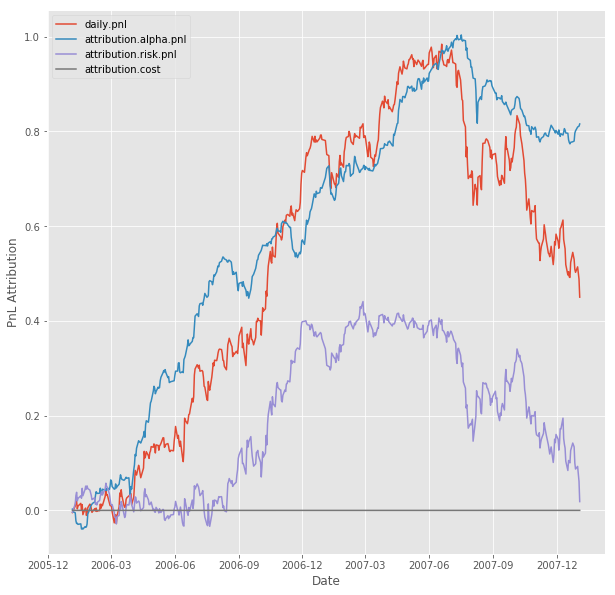

In [101]:
attr = build_pnl_attribution()

for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

**Portfolio Characteristics**
 - gross long positions
 - gross short positions
 - net positions
 - gross market value
 - dollar value traded

In [103]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = dates)
    
    for dt in dates:
        date = dt.strftime('%Y%m%d')
  
        p = port[date]
        tradelist = trades[date]
        h = p['opt.portfolio']['h.opt']
        
        df.at[dt,"long"] = sum(np.where(h < 0, 0, h))
        df.at[dt,"short"] = sum(np.where(h > 0, 0, h))
        df.at[dt,"net"] = sum(h)
        df.at[dt,"gmv"] = sum(np.abs(h))
        df.at[dt,"traded"] = sum(np.abs(tradelist['h.opt'] - tradelist['h.opt.previous']))
        
    return df

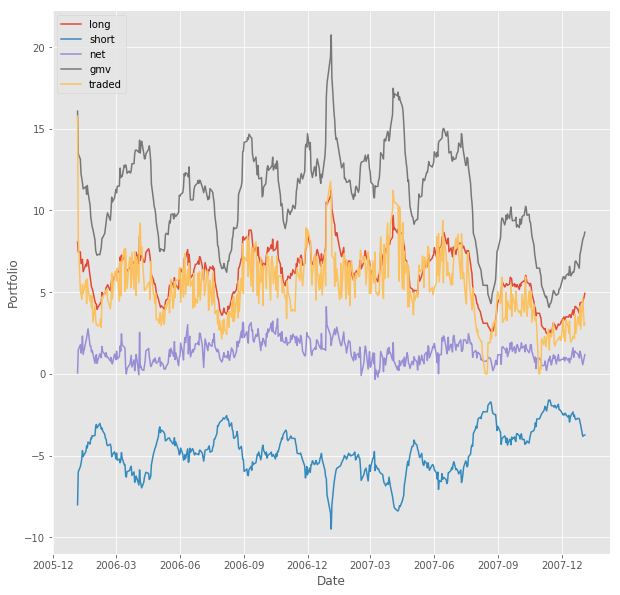

In [104]:
pchar = build_portfolio_characteristics()

for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()